# Data Balancing and Bias Mitigation Strategies

**Dataset:** Women in Data Science (91,713 encounters)  
**Task:** Understanding Data  
**Date:** February 17, 2025  
**Authors:** Mackenzie Meni & Jeremy Balch

### To Do List

- [x] Upsampling and downsampling and assess performance by category  
- [ ] Debiasing strategies  
- [x] Switch model architecture (RF, XGBoost, etc.)  
- [ ] Switch feature set (use all features, use subset of features)  
- [x] Switch evaluation metric (AUROC, Accuracy, etc.)  
- [x] Bootstrap for confidence intervals 


# Import all necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import TableOne
import warnings
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

warnings.filterwarnings("ignore")


# Load all data

In [2]:
# Loading original dataset
original_data = pd.read_csv('../preprocessed_data.csv')

# Loading altered dataset
data_altered_complete = pd.read_csv('../data_altered_complete.csv')

# Loading the models for comparison

In [3]:
# Random Forest Original
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")

# Random Forest Altered 20% African American
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Random Forest Altered 80% Female

# Random Forest Model with upsampled data

## Train/Test Split for Upsampling

- With stratify=y, both train and test sets will preserve the ratio of the classes from the original data, making the results more representative and the model's performance more reliable.

In [4]:
data = original_data

# Drop unnecessary columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define features and target
X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

# Split data first (before upsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Assign class weights automatically (higher weight for underrepresented class)
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_balanced.fit(X_train, y_train)

# Make predictions
y_pred = rf_model_balanced.predict(X_test)
y_pred_proba = rf_model_balanced.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.92
AUROC: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     14210
           1       0.57      0.14      0.22      1305

    accuracy                           0.92     15515
   macro avg       0.75      0.56      0.59     15515
weighted avg       0.90      0.92      0.90     15515

Confusion Matrix:
[[14075   135]
 [ 1123   182]]


# Upsampling the minority class for prediction

This function balances an imbalanced dataset by duplicating (upsampling) the minority class so that it has the same number of samples as the majority class.

**🔍 Example Before & After**

| Class         | Original Count | After Upsampling |
|--------------|---------------|------------------|
| Survived (0) | 10,000        | 10,000          |
| Died (1)     | 2,000         | 10,000 (upsampled) |


In [35]:
# **True Upsampling (Duplicate Minority Class)**
def upsample_minority(X, y):
    df = pd.concat([X, y], axis=1)
    
    # Separate majority and minority classes
    majority = df[df['hospital_death'] == 0]
    minority = df[df['hospital_death'] == 1]
    
    print(majority.shape)
    print(minority.shape)
    # Upsample the minority class by repeating existing samples
    minority_upsampled = minority.sample(n=len(majority), replace=True, random_state=42)

    # Combine the upsampled minority class with the majority class
    upsampled_df = pd.concat([majority, minority_upsampled])

    # Shuffle the dataset to mix samples well
    upsampled_df = upsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return upsampled_df.drop(columns=['hospital_death']), upsampled_df['hospital_death']

# Apply the upsampling and train the Random forest model

In [23]:

# Apply upsampling
X_train_upsampled, y_train_upsampled = upsample_minority(X_train, y_train)

# Train a Random Forest model on upsampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_upsampled, y_train_upsampled)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(rf_model, "../upsampled_random_forest_model.pkl")


(56842, 39)
(5218, 39)
Accuracy: 0.92
AUROC: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14210
           1       0.52      0.27      0.36      1305

    accuracy                           0.92     15515
   macro avg       0.73      0.63      0.66     15515
weighted avg       0.90      0.92      0.91     15515

Confusion Matrix:
[[13882   328]
 [  948   357]]


['../upsampled_random_forest_model.pkl']

## Upsampled Model Results Summary

**Comparison of Original to upsampled**

|  | **Original Model** | **Upsampled Model** | **Changes in the Upsampled Model Compared to Original** |
|--------------------|----------------|----------------|----------------|
| **True Positives (Correct Deaths)** | 269 | **357** | **+88 (Better at catching deaths)** |
| **False Negatives (Missed Deaths)** | 1,032 | **948** | **-84 (Fewer missed high-risk patients)** |
| **False Positives (Wrongly Predicted Deaths)** | 187 | **328** | **+141 (More cautious in predicting risk)** |
| **True Negatives (Correctly Predicted Survivals)** | 14,027 | **13,882** | **-145 (Slight decrease in correctly classified survivals)** |



The upsampled model improves detection of high-risk patients by reducing missed deaths (false negatives) from 1,032 to 948 and correctly identifying 88 more deaths than the original model. However, this comes with a trade-off—more false positives, increasing from 187 to 328, meaning the model is now more cautious in predicting risk.

Overall, the model prioritizes catching more hospital deaths, which is often preferable in healthcare settings where missing critical cases is riskier than raising extra alerts.

# Let's try downsampling the majority class instead


### Downsampling the Majority Class for Prediction

This function balances an imbalanced dataset by reducing (downsampling) the majority class so that it has the same number of samples as the minority class. Instead of adding synthetic or duplicate data, it randomly removes majority-class examples to create a more balanced dataset.

🔍 Example Before & After

| Class         | Original Count | After Downsampling |
|--------------|---------------|------------------|
| Survived (0) | 10,000        | 2,000  (downsampled) |
| Died (1)     | 2,000         | 2,000  |


This method helps prevent the model from overfitting to the majority class while ensuring that both classes are treated equally during training.

In [25]:
# **True Downsampling (Reduce Majority Class)**
def downsample_majority(X, y):
    df = pd.concat([X, y], axis=1)
    
    # Separate majority and minority classes
    majority = df[df['hospital_death'] == 0]
    minority = df[df['hospital_death'] == 1]
    
    print("Majority class size before downsampling:", majority.shape)
    print("Minority class size:", minority.shape)

    # Downsample the majority class to match the minority class
    majority_downsampled = majority.sample(n=len(minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    downsampled_df = pd.concat([majority_downsampled, minority])

    # Shuffle the dataset to mix samples well
    downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return downsampled_df.drop(columns=['hospital_death']), downsampled_df['hospital_death']

## Apply the downsampling and retrain a random forest model

In [26]:
data = original_data

# Drop unnecessary columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define features and target
X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

# Split data first (before upsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Apply downsampling
X_train_downsampled, y_train_downsampled = downsample_majority(X_train, y_train)

# Train a Random Forest model on upsampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_downsampled, y_train_downsampled)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(rf_model, "../downsampled_random_forest_model.pkl")


Majority class size before downsampling: (56842, 39)
Minority class size: (5218, 39)
Accuracy: 0.77
AUROC: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     14210
           1       0.23      0.78      0.36      1305

    accuracy                           0.77     15515
   macro avg       0.60      0.77      0.61     15515
weighted avg       0.91      0.77      0.82     15515

Confusion Matrix:
[[10893  3317]
 [  287  1018]]


['../downsampled_random_forest_model.pkl']

## Downsampled Model Results Summary
After downsampling, the model learns more evenly from both classes, leading to higher recall for the minority class (78%) but lower precision (23%).

- Accuracy (77%) is lower than the original model, but this is expected since we now prioritize balancing class predictions.
- AUROC (0.84) shows the model is still good at distinguishing between classes.
- Recall for hospital deaths (78%) improved significantly, meaning the model is much better at catching high-risk patients.
- Precision for hospital deaths (23%) is low, indicating more false positives.
- False negatives dropped from 1,032 (original model) to 287, meaning fewer missed critical cases.

The trade-off: fewer missed deaths (higher recall) but more false alarms (lower precision). This approach ensures more cautious risk prediction, which is often preferable in healthcare applications.

# Analyzing the bias per category


In [ ]:
# Choose which categories to analyze
original_data.columns

## Flexible Bias Assessment Function
This code checks if the AI model is fair by seeing how well it predicts hospital outcomes for different groups, like gender and ethnicity. It looks at accuracy (how often the model is right) and AUROC (how well it separates high-risk from low-risk patients).

If the model performs worse for certain groups, it might be biased, meaning it doesn't work equally well for everyone. This helps us identify unfairness and improve the model to make healthcare predictions more fair and reliable.

In [62]:

# **Flexible Bias Assessment Function**
def assess_bias(model, X_test, y_test, feature_name):
    """Evaluate model performance for different demographic groups."""
    
    # Ensure the feature exists in the dataset
    if feature_name not in X_test.columns:
        print(f"Skipping {feature_name}: Not found in dataset")
        return pd.DataFrame(columns=["Category", "Accuracy", "AUROC"])
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Check if model supports `predict_proba` (some models like SVM do not)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred  # Use predictions directly if no probabilities are available
    
    # Analyze performance across each category
    categories = X_test[feature_name].unique()
    results = []

    for category in categories:
        mask = X_test[feature_name] == category  # Boolean mask
        y_true_group = y_test[mask]
        y_pred_group = y_pred[mask]
        y_proba_group = y_pred_proba[mask]

        if len(y_true_group) == 0:
            continue  # Skip if no data for this category

        accuracy_group = accuracy_score(y_true_group, y_pred_group)
        auroc_group = roc_auc_score(y_true_group, y_proba_group) if len(set(y_true_group)) > 1 else np.nan  # Avoid AUROC error for single class

        results.append([category, accuracy_group, auroc_group])

    return pd.DataFrame(results, columns=["Category", "Accuracy", "AUROC"])


# **Example: Running Bias Analysis for Any Model**

    # Choose which features to evaluate
def evaluate_model(model, X_test, y_test):
    features_to_check = ["gender_F", "ethnicity_Caucasian", "ethnicity_African American", "ethnicity_Hispanic", "ethnicity_Native American"]

    for feature in features_to_check:
        print(f"\nBias Analysis for {feature}:")
        bias_results = assess_bias(model, X_test, y_test, feature)
        print(bias_results)




In [ ]:
# Evaluate the models

model = joblib.load('../upsampled_random_forest_model.pkl')



print("\n🔍 Evaluating Random Forest:")
evaluate_model(original_rf_loaded, X_test, y_test)





🔍 Evaluating Random Forest:

Bias Analysis for gender_F:
   Category  Accuracy     AUROC
0      True  0.984388  0.978182
1     False  0.987032  0.987096

Bias Analysis for ethnicity_Caucasian:
   Category  Accuracy     AUROC
0     False  0.987024  0.987603
1      True  0.985454  0.981697

Bias Analysis for ethnicity_African American:
   Category  Accuracy     AUROC
0     False  0.985601  0.982761
1      True  0.987611  0.985203

Bias Analysis for ethnicity_Hispanic:
   Category  Accuracy     AUROC
0     False  0.985807  0.982350
1      True  0.986111  0.996257

Bias Analysis for ethnicity_Native American:
   Category  Accuracy    AUROC
0     False  0.985820  0.98281
1      True  0.985816  0.99750


# Debiasing Techniques

# Reweighting biased data set for training

In [23]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Load Data
data_altered = pd.read_csv('../data_altered_complete.csv')

# Drop unused columns
data_altered = data_altered.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define features and target variable
X = data_altered.drop('hospital_death', axis=1)  
y = data_altered['hospital_death']               

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **1️⃣ Apply Reweighing to Correct Bias**
protected_attrs = ['ethnicity_African American']

# Convert dataset into BinaryLabelDataset format
dataset = BinaryLabelDataset(
    df=data_altered,
    label_names=['hospital_death'],
    protected_attribute_names=protected_attrs
)

reweigher = Reweighing(
    unprivileged_groups=[{'ethnicity_African American': 0}],  # Underrepresented class
    privileged_groups=[{'ethnicity_African American': 1}]  # Majority class
)

dataset_transf = reweigher.fit_transform(dataset)

# Convert back to Pandas
data_reweighted, _ = dataset_transf.convert_to_dataframe()
sample_weights = dataset_transf.instance_weights  

# **2️⃣ Train a Model with Reweighted Data**
X = data_reweighted.drop(columns=['hospital_death'])
y = data_reweighted['hospital_death']

X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# Train model using reweighted samples
rf_model_reweighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_reweighted.fit(X_train, y_train, sample_weight=sample_weights_train)

# Save Model
joblib.dump(rf_model_reweighted, '../rf_reweighted.pkl')

# Make Predictions
y_pred_reweighted = rf_model_reweighted.predict(X_test)
y_pred_reweighted_proba = rf_model_reweighted.predict_proba(X_test)[:, 1]

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred_reweighted)
auroc = roc_auc_score(y_test, y_pred_reweighted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_reweighted))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_reweighted))


Accuracy: 0.88
AUROC: 0.84
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94     13679
         1.0       0.49      0.17      0.25      1836

    accuracy                           0.88     15515
   macro avg       0.69      0.57      0.59     15515
weighted avg       0.85      0.88      0.85     15515

Confusion Matrix:
[[13356   323]
 [ 1524   312]]


# Thresholding

In [25]:
from sklearn.metrics import roc_curve

# Compute FPR, TPR for African American and Others
fpr, tpr, thresholds = roc_curve(y_test, y_pred_reweighted_proba)

# Set a new threshold where FPR is balanced
optimal_idx = np.argmax(tpr - fpr)  
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold for Fairness: {optimal_threshold:.3f}")

# Apply new threshold
y_pred_adjusted = (y_pred_reweighted_proba >= optimal_threshold).astype(int)

# Recompute metrics
accuracy_adj = accuracy_score(y_test, y_pred_adjusted)
auroc_adj = roc_auc_score(y_test, y_pred_adjusted)

print(f"Adjusted Accuracy: {accuracy_adj:.2f}")
print(f"Adjusted AUROC: {auroc_adj:.2f}")
print("Adjusted Classification Report:")
print(classification_report(y_test, y_pred_adjusted))
print("Adjusted Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))


Optimal Threshold for Fairness: 0.130
Adjusted Accuracy: 0.77
Adjusted AUROC: 0.78
Adjusted Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     13679
         1.0       0.31      0.79      0.44      1836

    accuracy                           0.77     15515
   macro avg       0.64      0.78      0.65     15515
weighted avg       0.89      0.77      0.80     15515

Adjusted Confusion Matrix:
[[10428  3251]
 [  385  1451]]


In [27]:
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# Convert dataset to aif360 format
dataset = BinaryLabelDataset(
    df=data_altered,
    label_names=['hospital_death'],
    protected_attribute_names=['ethnicity_African American']
)

# Train Adversarial Debiasing Model
sess = tf.Session()
adv_debiasing = AdversarialDebiasing(
    privileged_groups=[{'ethnicity_African American': 1}],
    unprivileged_groups=[{'ethnicity_African American': 0}],
    scope_name='debiased_classifier',
    debias=True,
    sess=sess
)

adv_debiasing.fit(dataset)

# Make Predictions
y_pred_adv = adv_debiasing.predict(dataset).labels

# Evaluate
accuracy_adv = accuracy_score(y_test, y_pred_adv)
print(f"Adversarial Debiasing Accuracy: {accuracy_adv:.2f}")


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2025-02-18 14:21:36.923783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 5192.291504; batch adversarial loss: 0.460821
epoch 0; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 400; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 600; batch classifier loss: nan; batch adversarial loss: nan
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 1; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 1; iter: 400; batch classifier loss: nan; batch adversarial loss: nan
epoch 1; iter: 600; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 400; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 600; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3

KeyboardInterrupt: 

# Comparing metrics after reweighting

Bias Metrics Comparison
                    Ethnicity  Disparate Impact_Original  \
0  ethnicity_African American                   0.775735   
1             ethnicity_Asian                   0.778643   
2         ethnicity_Caucasian                   0.772017   
3          ethnicity_Hispanic                   0.811813   
4   ethnicity_Native American                   0.847340   

   Disparate Impact_Biased  Disparate Impact_Reweighted  \
0                 0.575579                     0.163076   
1                 0.700778                     0.345954   
2                 0.855206                     0.319890   
3                 0.885069                     0.694637   
4                 0.635167                     0.841521   

   Equalized Odds Diff_Original  Equalized Odds Diff_Biased  \
0                      0.190324                    0.107304   
1                      0.010683                    0.174119   
2                      0.157528                    0.072113   
3       

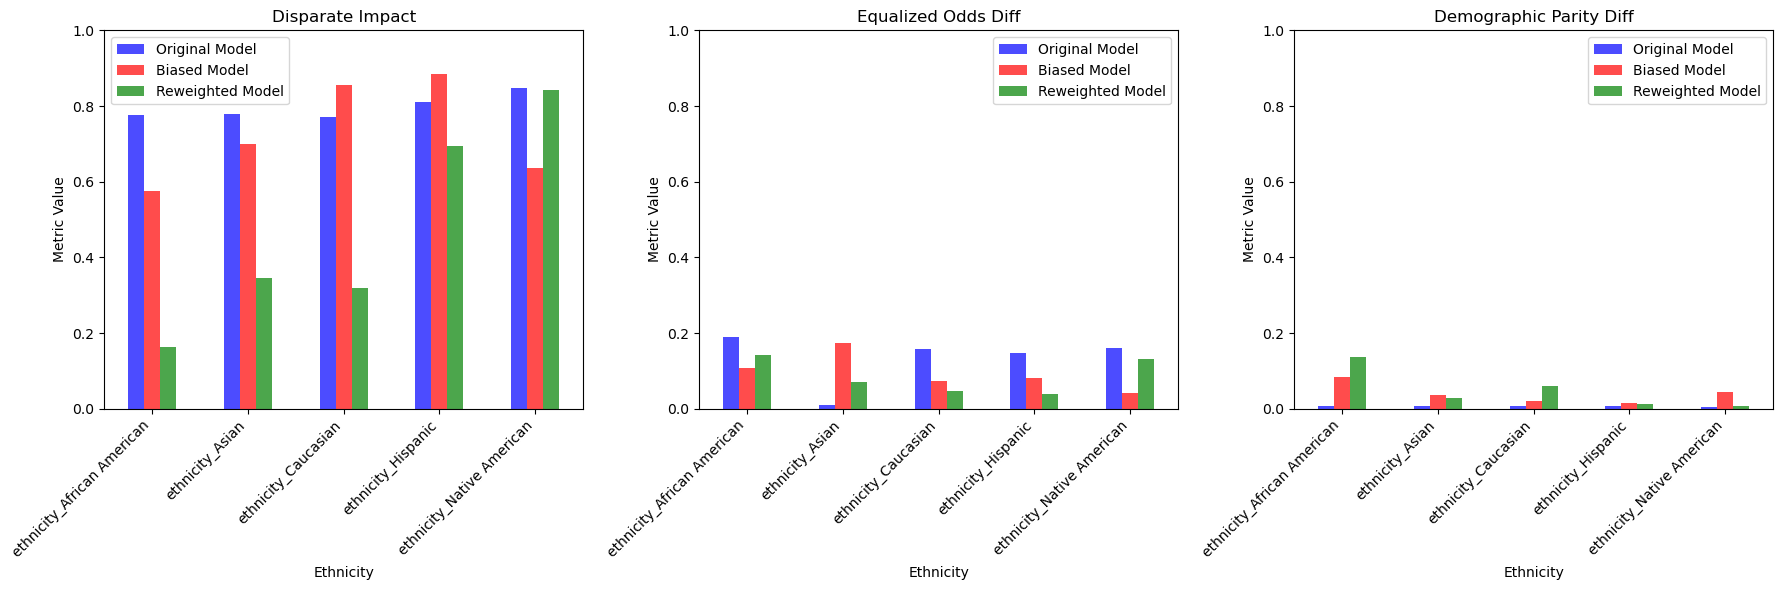

In [26]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt
import pandas as pd

# List of ethnic groups to analyze
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

# Function to compute bias metrics per ethnic group
def compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, y_pred_reweighted, ethnicity_columns):
    """Computes Disparate Impact, Equalized Odds Difference, and Demographic Parity Difference per ethnicity."""
    bias_results = []

    for ethnicity in ethnicity_columns:
        di_orig = disparate_impact(y_test, y_pred_orig, ethnicity)
        di_bias = disparate_impact(y_test, y_pred_bias, ethnicity)
        di_reweighted = disparate_impact(y_test, y_pred_reweighted,ethnicity)

        eo_orig = equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        eo_bias = equalized_odds_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])
        eo_reweighted = equalized_odds_difference(y_test, y_pred_reweighted, sensitive_features=X_test[ethnicity])

        dp_orig = demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        dp_bias = demographic_parity_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])
        dp_reweighted = demographic_parity_difference(y_test, y_pred_reweighted, sensitive_features=X_test[ethnicity])

        bias_results.append({
            "Ethnicity": ethnicity,
            "Disparate Impact_Original": di_orig,
            "Disparate Impact_Biased": di_bias,
            "Disparate Impact_Reweighted": di_reweighted,
            "Equalized Odds Diff_Original": eo_orig,
            "Equalized Odds Diff_Biased": eo_bias,
            "Equalized Odds Diff_Reweighted": eo_reweighted,
            "Demographic Parity Diff_Original": dp_orig,
            "Demographic Parity Diff_Biased": dp_bias,
            "Demographic Parity Diff_Reweighted": dp_reweighted
        })

    return pd.DataFrame(bias_results)

# Compute bias metrics for all ethnic groups
bias_results_df = compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, y_pred_reweighted, ethnicity_columns)

# Display Bias Metrics
print("Bias Metrics Comparison")
print(bias_results_df)

## Visualization Fix
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ["Disparate Impact", "Equalized Odds Diff", "Demographic Parity Diff"]
columns = [
    ("Disparate Impact_Original", "Disparate Impact_Biased", "Disparate Impact_Reweighted"),
    ("Equalized Odds Diff_Original", "Equalized Odds Diff_Biased", "Equalized Odds Diff_Reweighted"),
    ("Demographic Parity Diff_Original", "Demographic Parity Diff_Biased", "Demographic Parity Diff_Reweighted"),
]

for i, (metric, (orig_col, bias_col, reweighted_col)) in enumerate(zip(metrics, columns)):
    ax = axes[i]
    bias_results_df.plot(
        kind="bar", x="Ethnicity", y=[orig_col, bias_col, reweighted_col],
        color=["blue", "red", "green"], alpha=0.7, ax=ax
    )
    ax.set_title(metric)
    ax.set_ylabel("Metric Value")
    ax.set_xticklabels(bias_results_df["Ethnicity"], rotation=45, ha="right")
    ax.legend(["Original Model", "Biased Model", "Reweighted Model"])
    
    # Add consistent y-axis scaling
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()
